<a href="https://colab.research.google.com/github/SanuKumar4245/it-cert-automation-practice/blob/master/Transfer_Learning_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the dataset folder in your Google Drive
dataset_dir = '/content/drive/MyDrive/Dataset'


Mounted at /content/drive


In [4]:
# Set the image and batch size
img_width, img_height = 224, 224
batch_size = 32

In [5]:
# Create data generators with data augmentation for training and validation data
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data_dir = dataset_dir + '/Train'
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_data_dir = dataset_dir + '/Test'
validation_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


Found 750 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


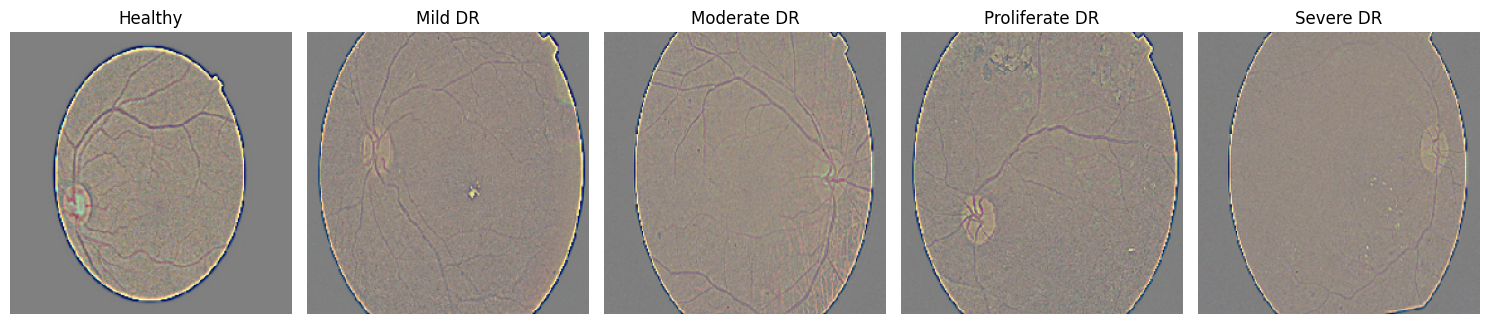

In [26]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set the number of images to display per class
num_images_per_class = 1

# Get the class labels and their corresponding indices
class_indices = validation_generator.class_indices
class_labels = list(class_indices.keys())

# Create a figure to display the images
fig, axes = plt.subplots(nrows=num_images_per_class, ncols=len(class_labels), figsize=(15, 5))

# Loop through each class
for i, label in enumerate(class_labels):
    # Get the directory for the current class
    class_dir = os.path.join(test_data_dir, label)

    # Get a list of image file names in the class directory
    image_files = os.listdir(class_dir)

    # Randomly select one image from the class
    selected_image = random.choice(image_files)

    # Load and display the selected image
    img_path = os.path.join(class_dir, selected_image)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


In [6]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [7]:
# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False


In [8]:
# Create a new model and add the base VGG16 model as a layer
model = Sequential()
model.add(base_model)
model.add(Flatten())

# Add a fully connected layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Add dropout regularization

# Add another fully connected layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Add dropout regularization

# Add the final classification layer with softmax activation
model.add(Dense(5, activation='softmax'))

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for a larger number of epochs
epochs = 20
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size)

Epoch 1/20
23/23 [==============================] - 348s 15s/step - loss: 1.6614 - accuracy: 0.2925 - val_loss: 1.3619 - val_accuracy: 0.3125
Epoch 2/20
23/23 [==============================] - 339s 15s/step - loss: 1.4790 - accuracy: 0.3426 - val_loss: 1.3104 - val_accuracy: 0.4479
Epoch 3/20
23/23 [==============================] - 337s 15s/step - loss: 1.4304 - accuracy: 0.3524 - val_loss: 1.3140 - val_accuracy: 0.3750
Epoch 4/20
23/23 [==============================] - 343s 15s/step - loss: 1.4260 - accuracy: 0.3524 - val_loss: 1.2854 - val_accuracy: 0.4688
Epoch 5/20
23/23 [==============================] - 342s 15s/step - loss: 1.4028 - accuracy: 0.3538 - val_loss: 1.2968 - val_accuracy: 0.5000
Epoch 6/20
23/23 [==============================] - 340s 15s/step - loss: 1.3838 - accuracy: 0.3969 - val_loss: 1.2717 - val_accuracy: 0.3958
Epoch 7/20
23/23 [==============================] - 341s 15s/step - loss: 1.3991 - accuracy: 0.3412 - val_loss: 1.3059 - val_accuracy: 0.3854
Epoch 

In [12]:
# Class labels
class_labels = list(train_generator.class_indices.keys())
print('Class Labels:', class_labels)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Class Labels: ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
3/3 [==============================] - 39s 13s/step - loss: 1.2135 - accuracy: 0.4271
Test Loss: 1.213509440422058
Test Accuracy: 0.4270833432674408


In [13]:
from tensorflow.keras.preprocessing import image
# Random image path for prediction
random_image_path = '/content/drive/MyDrive/Dataset/Train/Severe DR/Severe DR_108.png'

# Load and preprocess the random image
img = image.load_img(random_image_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Make predictions on the random image
predictions = model.predict(img_array)
predicted_label = class_labels[np.argmax(predictions)]

print('Predicted Label:', predicted_label)

1/1 [==============================] - 0s 387ms/step
Predicted Label: Severe DR


Found 100 images belonging to 5 classes.
100/100 [==============================] - 45s 445ms/step


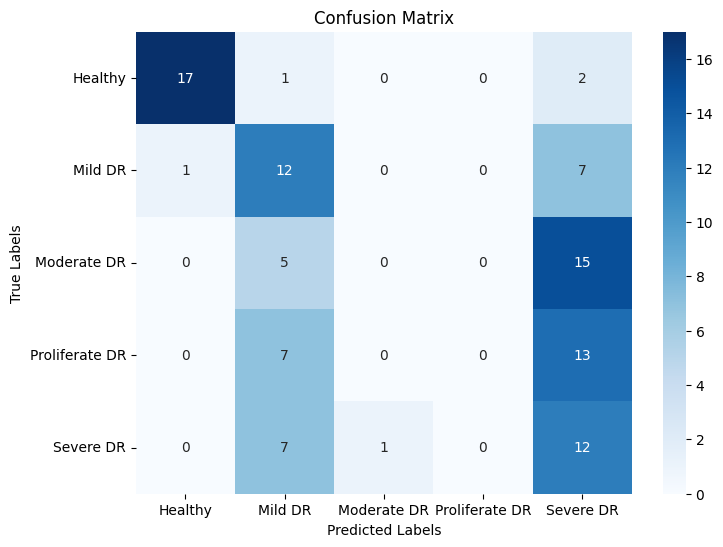

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predictions for the test data
test_data_dir = dataset_dir + '/Test'
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode='categorical')

# Generate predictions
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


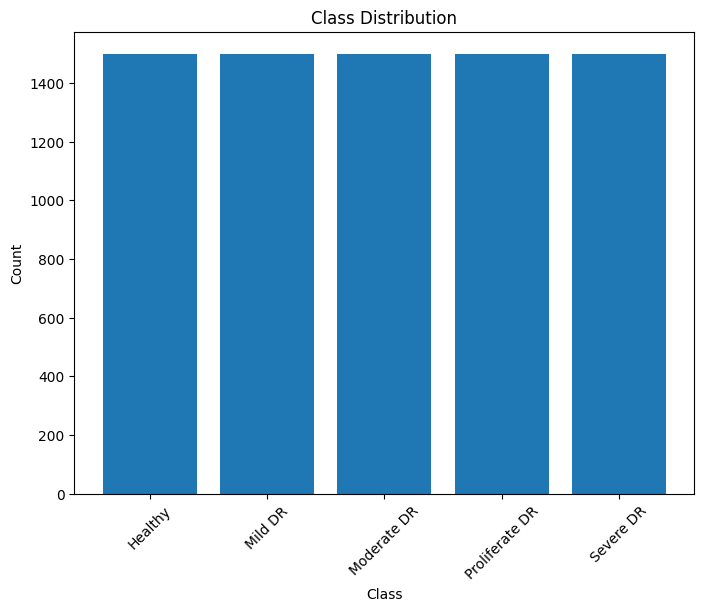

In [44]:
# Count the number of samples in each class
class_counts = train_generator.labels.sum(axis=0)

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()
